In [1]:
# Preprocesamiento, entrenamiento y evaluación ELECTRA-large SIN AJUSTE PARA HUMAN FACTORS

from transformers import ElectraTokenizer, ElectraModel, ElectraConfig, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, multilabel_confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import itertools

# Definición de dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carga y preparación de datos
EPOCHS = 3

# Carga y preparación de datos
df = pd.read_csv('ASRS20002023dataset.csv', sep=';', low_memory=False)
df['ContributingFactors'] = df['ContributingFactors'].fillna('').apply(lambda x: [factor.strip() for factor in x.split(';')] if x != '' else [])

etiquetas = [
    'Aircraft', 'Airport', 'Airspace Structure', 'ATC Equipment / Nav Facility / Buildings',
    'Chart Or Publication', 'Company Policy', 'Equipment / Tooling', 'Environment - Non Weather Related',
    'Human Factors', 'Incorrect / Not Installed / Unavailable Part', 'Logbook Entry', 'Manuals',
    'MEL', 'Procedure', 'Software and Automation', 'Staffing', 'Weather', 'Ambiguous'
]

mlb = MultiLabelBinarizer()
mlb.fit([etiquetas])

df['multilabels'] = df.apply(lambda x: mlb.transform([[x['PrimaryProblem']] + x['ContributingFactors']])[0], axis=1)

tokenizer = ElectraTokenizer.from_pretrained('google/electra-large-discriminator')

class ASRSDataset(Dataset):
    def __init__(self, narratives, labels):
        self.narratives = narratives
        self.labels = labels
    
    def __len__(self):
        return len(self.narratives)
    
    def __getitem__(self, idx):
        narrative = self.narratives[idx]
        label = self.labels[idx]
        encoding = tokenizer(narrative, padding='max_length', truncation=True, max_length=128, return_tensors="pt")
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.FloatTensor(label)
        }

narratives = df['Narrative'].tolist()
labels = list(df['multilabels'].values)
dataset = ASRSDataset(narratives, labels)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Modelo
class ElectraMultiLabelClassifier(torch.nn.Module):
    def __init__(self, num_labels):
        super(ElectraMultiLabelClassifier, self).__init__()
        self.config = ElectraConfig.from_pretrained('google/electra-large-discriminator', num_labels=num_labels)
        self.electra = ElectraModel.from_pretrained('google/electra-large-discriminator', config=self.config)
        self.classifier = torch.nn.Linear(self.config.hidden_size, num_labels)
        self.loss_fct = torch.nn.BCEWithLogitsLoss()
    
    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.electra(input_ids=input_ids, attention_mask=attention_mask)
        logits = self.classifier(outputs.last_hidden_state[:,0,:])  # Usar la representación del token [CLS]
        loss = None
        if labels is not None:
            loss = self.loss_fct(logits, labels)
        return loss, logits

# No es necesario inicializar y ajustar los pesos para 'Human Factors'
model = ElectraMultiLabelClassifier(len(mlb.classes_)).to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * EPOCHS)

#Entrenamiento
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{EPOCHS}', leave=False)
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        model.zero_grad()
        loss, _ = model(input_ids, attention_mask, labels=labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix({'Training Loss': f'{total_loss / len(train_loader):.4f}'})
    
    print(f'Epoch {epoch + 1}/{EPOCHS}, Training Loss: {total_loss / len(train_loader):.4f}')

# Evaluación
model.eval()  # Poner el modelo en modo evaluación
total_eval_accuracy = 0
total_eval_loss = 0
total_samples = 0

y_pred = []
y_true = []

with torch.no_grad():  # No calcular gradientes
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask, labels=labels)
        loss, logits = outputs

        total_eval_loss += loss.item()
        
        # Calcular precisión para el lote actual
        preds = torch.sigmoid(logits).round()  # Asumiendo salida binaria o multietiqueta
        accuracy = (preds == labels).float().mean()
        total_eval_accuracy += accuracy.item() * input_ids.size(0)
        total_samples += input_ids.size(0)

        # Almacenar predicciones y etiquetas verdaderas para métricas adicionales
        y_pred.append(preds.cpu().numpy())
        y_true.append(labels.cpu().numpy())

# Calcular la precisión total
avg_eval_accuracy = total_eval_accuracy / total_samples
avg_eval_loss = total_eval_loss / len(val_loader)

print(f"Validation Loss: {avg_eval_loss:.4f}")
print(f"Validation Accuracy: {avg_eval_accuracy:.4f}")


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.11/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.9
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.11/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/usr/local/lib/python3.11/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib'), PosixPath('/usr/local/nvidia/lib64')}
  warn(msg)
/usr/local/lib/python3.11/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/local/nvidia/lib:/usr/local/nvidia/lib64 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.11/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('module'), PosixPath('//matplotlib_inline.backend_inline')}
  warn(msg)
/usr/local/lib/python3.11/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: Found duplicate ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] files: {PosixPath('/usr/local/cuda/lib64/libcudart

Epoch 1/3:   0%|          | 0/6885 [00:00<?, ?it/s]

Epoch 1/3, Training Loss: 0.2643


Epoch 2/3:   0%|          | 0/6885 [00:00<?, ?it/s]

Epoch 2/3, Training Loss: 0.2631


Epoch 3/3:   0%|          | 0/6885 [00:00<?, ?it/s]

Epoch 3/3, Training Loss: 0.2629
Validation Loss: 0.2640
Validation Accuracy: 0.9008


Global Precision: 0.6943
Global Recall: 0.3192
Global F1-Score: 0.4374
Precision (Human Factors): 0.6943
Recall (Human Factors): 1.0000
F1-Score (Human Factors): 0.8196


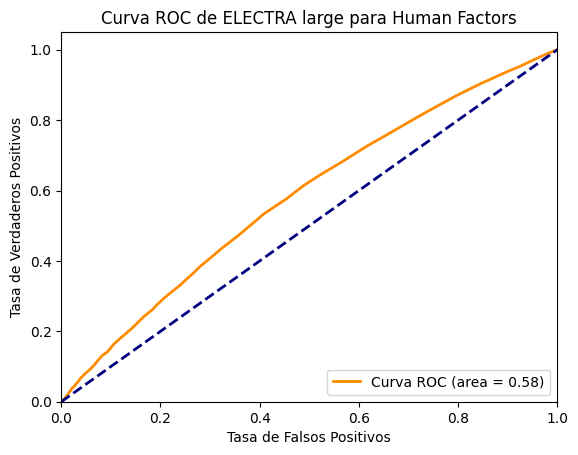

In [2]:
#Calculo de métricas adicionales

import numpy as np
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
from itertools import product

model.eval()
y_pred_probs = []
y_true = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Asegúrate de recibir solo los logits aquí
        logits = model(input_ids, attention_mask)[1] if isinstance(model(input_ids, attention_mask), tuple) else model(input_ids, attention_mask)
        probs = torch.sigmoid(logits)
        
        y_pred_probs.append(probs.cpu().numpy())
        y_true.append(labels.cpu().numpy())

y_pred_probs = np.concatenate(y_pred_probs, axis=0)
y_true = np.concatenate(y_true, axis=0)
y_pred = (y_pred_probs > 0.5).astype(int)

# Métricas globales
global_precision = precision_score(y_true, y_pred, average='micro')
global_recall = recall_score(y_true, y_pred, average='micro')
global_f1 = f1_score(y_true, y_pred, average='micro')
print(f"Global Precision: {global_precision:.4f}")
print(f"Global Recall: {global_recall:.4f}")
print(f"Global F1-Score: {global_f1:.4f}")

# Métricas para 'Human Factors'
index_human_factors = list(mlb.classes_).index('Human Factors')
precision_hf, recall_hf, f1_hf = precision_score(y_true[:, index_human_factors], y_pred[:, index_human_factors]), recall_score(y_true[:, index_human_factors], y_pred[:, index_human_factors]), f1_score(y_true[:, index_human_factors], y_pred[:, index_human_factors])
print(f"Precision (Human Factors): {precision_hf:.4f}")
print(f"Recall (Human Factors): {recall_hf:.4f}")
print(f"F1-Score (Human Factors): {f1_hf:.4f}")

# Curva ROC y AUC para 'Human Factors'
fpr, tpr, _ = roc_curve(y_true[:, index_human_factors], y_pred_probs[:, index_human_factors])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC de ELECTRA large para Human Factors')
plt.legend(loc="lower right")
plt.savefig('Curva ROC ELECTRAlarge.png')
plt.show()

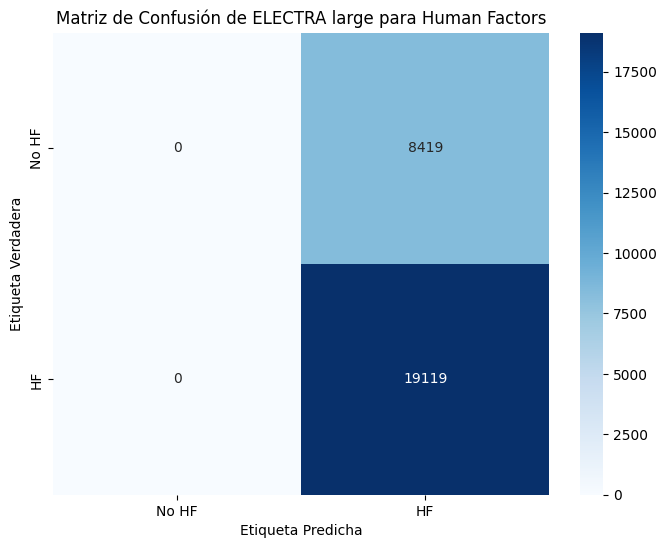

In [3]:
# Matriz de confusión para Human Factors

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Asumiendo que 'index_human_factors' es el índice de 'Human Factors' en tus etiquetas
index_human_factors = list(mlb.classes_).index('Human Factors')

# Extraer las etiquetas verdaderas y predichas específicamente para 'Human Factors'
y_true_hf = y_true[:, index_human_factors]
y_pred_hf = y_pred[:, index_human_factors]

# Generar la matriz de confusión
cm = confusion_matrix(y_true_hf, y_pred_hf)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No HF", "HF"], yticklabels=["No HF", "HF"])
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.title('Matriz de Confusión de ELECTRA large para Human Factors')
plt.savefig('MatrizConfusionELECTRA_large.png')
plt.show()